# NLP Review Classifier - Pretrained Model

In [56]:
# Imports
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Read in Data & Preprocess

In [4]:
# Read in data
df = pd.read_csv('drive/MyDrive/data/df_final.csv')

In [5]:
# Check data
df.head()

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice room not experience hotel monaco seattle ...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3


In [65]:
# Save all class names
class_names = np.sort(df['Rating'].unique()).tolist()

In [120]:
# Label encode targets
le = LabelEncoder()
df['Rating'] = le.fit_transform(df['Rating'])

In [145]:
# Remove 10% of data for testing and 10% for validation
df_train, df_test = train_test_split(df, test_size=0.2)
df_test, df_val = train_test_split(df_test, test_size=0.5)

In [146]:
# Split & preprocess data
(X_train, y_train), (X_val, y_val), preproc = text.texts_from_df(df_train, 'Review', label_columns=['Rating'],
                                                                val_df=df_val, preprocess_mode='bert')

['Rating_0', 'Rating_1', 'Rating_2', 'Rating_3', 'Rating_4']
       Rating_0  Rating_1  Rating_2  Rating_3  Rating_4
13255       0.0       1.0       0.0       0.0       0.0
12983       1.0       0.0       0.0       0.0       0.0
10867       0.0       1.0       0.0       0.0       0.0
10830       0.0       0.0       1.0       0.0       0.0
4990        1.0       0.0       0.0       0.0       0.0
['Rating_0', 'Rating_1', 'Rating_2', 'Rating_3', 'Rating_4']
       Rating_0  Rating_1  Rating_2  Rating_3  Rating_4
10619       0.0       1.0       0.0       0.0       0.0
642         0.0       0.0       0.0       0.0       1.0
8853        0.0       0.0       0.0       1.0       0.0
2617        0.0       0.0       0.0       1.0       0.0
12438       0.0       0.0       0.0       1.0       0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


## BERT

#### Build Model

In [147]:
# Create model
bert_model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 400
done.


In [148]:
# Create learner
learner = ktrain.get_learner(model=bert_model, train_data=(X_train, y_train), val_data=(X_val, y_val),
                             batch_size=6)

In [149]:
# Fit data
history = learner.fit_onecycle(lr=2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
2472/2472 [==============================] - 2047s 823ms/step - loss: 1.2076 - accuracy: 0.4438 - val_loss: 0.8927 - val_accuracy: 0.6084


In [150]:
# Get predictor
predictor = ktrain.get_predictor(learner.model, preproc)

In [151]:
# Example prediction
example_data = [
        'The hotel was really bad I do not like it ',
        'the room really sucked, I want my money back',
        'what a beautiful place'        
]

# Make predictions on example
predictor.predict(example_data)

['Rating_0', 'Rating_0', 'Rating_4']

In [152]:
# Get original labels for predictions
label_dict = {
    'Rating_0': 1,
    'Rating_1': 2,
    'Rating_2': 3,
    'Rating_3': 4,
    'Rating_4': 5
}

[label_dict[k] for k in predictor.predict(data)]

[1, 1, 5]

In [154]:
# Evaluate model on val set
learner.validate(val_data=(X_val, y_val), class_names=class_names)

              precision    recall  f1-score   support

           1       0.73      0.77      0.75       362
           2       0.56      0.56      0.56       361
           3       0.53      0.54      0.53       370
           4       0.51      0.49      0.50       382
           5       0.71      0.69      0.70       379

    accuracy                           0.61      1854
   macro avg       0.61      0.61      0.61      1854
weighted avg       0.61      0.61      0.61      1854



array([[280,  70,   8,   2,   2],
       [ 86, 201,  67,   7,   0],
       [ 18,  75, 198,  72,   7],
       [  0,   7,  89, 189,  97],
       [  1,   4,  15,  99, 260]])

#### Evaluate Model on Test Set

In [184]:
# Get predictions using test set
test_preds = predictor.predict(X_test.to_list())

In [186]:
# Convert textual predictions and ground truth labels into arrays
y_preds_arr = np.array([int(x[-1]) for x in test_preds])
y_test_arr = np.array(y_test)

In [190]:
# Calculate BERT model test accuracy
bert_accuracy = accuracy_score(y_test_arr, y_preds_arr)

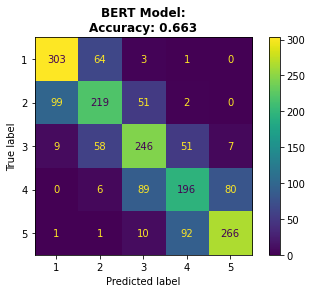

In [191]:
# Plot confusion matrix and accuracy for BERT model
cm = confusion_matrix(y_test_arr, y_preds_arr)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(values_format='d')
disp.ax_.set_title(f'BERT Model:\nAccuracy: {bert_accuracy:.3f}', fontweight='bold');

In [192]:
# Save model
learner.save_model('bert_model_final.h5')